In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.optimize import minimize
import matplotlib.pyplot as plt

This notebook compares several approaches on their ability to align the HOMO-LUMO and fundamental gaps for the structures in CSD-76-HFX.

In [2]:
tuning_data = pd.read_csv('../data/optimal_tuning.csv').set_index('Unnamed: 0')

LS_IP_scan_df = tuning_data[tuning_data.columns[tuning_data.columns.str.endswith('IP LS SCAN')]]
LS_IP_scan_df = LS_IP_scan_df.rename(columns={col: col.split()[0] for col in LS_IP_scan_df.columns})
HS_IP_scan_df = tuning_data[tuning_data.columns[tuning_data.columns.str.endswith('IP HS SCAN')]]
HS_IP_scan_df = HS_IP_scan_df.rename(columns={col: col.split()[0] for col in HS_IP_scan_df.columns})
LS_IP_pbe_df = tuning_data[tuning_data.columns[tuning_data.columns.str.endswith('IP LS PBE')]]
LS_IP_pbe_df = LS_IP_pbe_df.rename(columns={col: col.split()[0] for col in LS_IP_pbe_df.columns})
HS_IP_pbe_df = tuning_data[tuning_data.columns[tuning_data.columns.str.endswith('IP HS PBE')]]
HS_IP_pbe_df = HS_IP_pbe_df.rename(columns={col: col.split()[0] for col in HS_IP_pbe_df.columns})

LS_EA_scan_df = tuning_data[tuning_data.columns[tuning_data.columns.str.endswith('EA LS SCAN')]]
LS_EA_scan_df = LS_EA_scan_df.rename(columns={col: col.split()[0] for col in LS_EA_scan_df.columns})
HS_EA_scan_df = tuning_data[tuning_data.columns[tuning_data.columns.str.endswith('EA HS SCAN')]]
HS_EA_scan_df = HS_EA_scan_df.rename(columns={col: col.split()[0] for col in HS_EA_scan_df.columns})
LS_EA_pbe_df = tuning_data[tuning_data.columns[tuning_data.columns.str.endswith('EA LS PBE')]]
LS_EA_pbe_df = LS_EA_pbe_df.rename(columns={col: col.split()[0] for col in LS_EA_pbe_df.columns})
HS_EA_pbe_df = tuning_data[tuning_data.columns[tuning_data.columns.str.endswith('EA HS PBE')]]
HS_EA_pbe_df = HS_EA_pbe_df.rename(columns={col: col.split()[0] for col in HS_EA_pbe_df.columns})

LS_HOMO_scan_df = tuning_data[tuning_data.columns[tuning_data.columns.str.endswith('HOMO LS SCAN')]]
LS_HOMO_scan_df = LS_HOMO_scan_df.rename(columns={col: col.split()[0] for col in LS_HOMO_scan_df.columns})
HS_HOMO_scan_df = tuning_data[tuning_data.columns[tuning_data.columns.str.endswith('HOMO HS SCAN')]]
HS_HOMO_scan_df = HS_HOMO_scan_df.rename(columns={col: col.split()[0] for col in HS_HOMO_scan_df.columns})
LS_HOMO_pbe_df = tuning_data[tuning_data.columns[tuning_data.columns.str.endswith('HOMO LS PBE')]]
LS_HOMO_pbe_df = LS_HOMO_pbe_df.rename(columns={col: col.split()[0] for col in LS_HOMO_pbe_df.columns})
HS_HOMO_pbe_df = tuning_data[tuning_data.columns[tuning_data.columns.str.endswith('HOMO HS PBE')]]
HS_HOMO_pbe_df = HS_HOMO_pbe_df.rename(columns={col: col.split()[0] for col in HS_HOMO_pbe_df.columns})

LS_LUMO_scan_df = tuning_data[tuning_data.columns[tuning_data.columns.str.endswith('LUMO LS SCAN')]]
LS_LUMO_scan_df = LS_LUMO_scan_df.rename(columns={col: col.split()[0] for col in LS_LUMO_scan_df.columns})
HS_LUMO_scan_df = tuning_data[tuning_data.columns[tuning_data.columns.str.endswith('LUMO HS SCAN')]]
HS_LUMO_scan_df = HS_LUMO_scan_df.rename(columns={col: col.split()[0] for col in HS_LUMO_scan_df.columns})
LS_LUMO_pbe_df = tuning_data[tuning_data.columns[tuning_data.columns.str.endswith('LUMO LS PBE')]]
LS_LUMO_pbe_df = LS_LUMO_pbe_df.rename(columns={col: col.split()[0] for col in LS_LUMO_pbe_df.columns})
HS_LUMO_pbe_df = tuning_data[tuning_data.columns[tuning_data.columns.str.endswith('LUMO HS PBE')]]
HS_LUMO_pbe_df = HS_LUMO_pbe_df.rename(columns={col: col.split()[0] for col in HS_LUMO_pbe_df.columns})

structs = tuning_data.index

def interp(df, struct):
    '''
    Given a dataframe and a structure name, returns a function that interpolates the HFX range for that functional.
    '''
    x = []
    y = []
    for hfx in np.arange(0, 101, 5):
        yval = df[str(hfx)][struct]
        if not np.isnan(yval):
            x.append(hfx)
            y.append(yval)
    if len(x) < 5:
        return np.nan
    return interp1d(x, y, kind='linear', fill_value='extrapolate')

# 4 cases, LS SCAN, HS SCAN, LS PBE, HS PBE

In [3]:
tuned_targets = pd.read_csv('../data/tuned_targets.csv').set_index('Unnamed: 0')
tuned_targets['Tuned Avg PBE'] = (tuned_targets['Tuned HS PBE'] + tuned_targets['Tuned LS PBE'])/2
tuned_targets['Tuned Avg SCAN'] = (tuned_targets['Tuned HS SCAN'] + tuned_targets['Tuned LS SCAN'])/2

pbe_targets = pd.read_csv('../ml_training/DF-BP/pbe0_opt5/BP_predictions_hyperparams-test.csv').set_index('Unnamed: 0')
scan_targets = pd.read_csv('../ml_training/DF-BP/pbe0_opt5/BP_predictions_hyperparams-test.csv').set_index('Unnamed: 0')

In [4]:
def objective(HOMO_df, LUMO_df, IP_df, EA_df, structure, hfx):
    homo = interp(HOMO_df, structure)
    if callable(homo):
        homo = homo(hfx)
    lumo = interp(LUMO_df, structure)
    if callable(lumo):
        lumo = lumo(hfx)
    ip = interp(IP_df, structure)
    if callable(ip):
        ip = ip(hfx)
    ea = interp(EA_df, structure)
    if callable(ea):
        ea = ea(hfx)
    #return (homo + ip)**2 + (lumo + ea)**2
    return np.abs(np.abs(homo-lumo) - np.abs(ip-ea))

base_ls_errors_pbe = pd.DataFrame(index=structs, columns=['Optimal HFX', 'Error'])
base_hs_errors_pbe = pd.DataFrame(index=structs, columns=['Optimal HFX', 'Error'])
base_ls_errors_scan = pd.DataFrame(index=structs, columns=['Optimal HFX', 'Error'])
base_hs_errors_scan = pd.DataFrame(index=structs, columns=['Optimal HFX', 'Error'])

default_ls_errors_pbe = pd.DataFrame(index=structs, columns=['Optimal HFX', 'Error'])
default_hs_errors_pbe = pd.DataFrame(index=structs, columns=['Optimal HFX', 'Error'])
default_ls_errors_scan = pd.DataFrame(index=structs, columns=['Optimal HFX', 'Error'])
default_hs_errors_scan = pd.DataFrame(index=structs, columns=['Optimal HFX', 'Error'])

ls_ls_errors_pbe = pd.DataFrame(index=structs, columns=['Optimal HFX', 'Error'])
ls_hs_errors_pbe = pd.DataFrame(index=structs, columns=['Optimal HFX', 'Error'])
hs_ls_errors_pbe = pd.DataFrame(index=structs, columns=['Optimal HFX', 'Error'])
hs_hs_errors_pbe = pd.DataFrame(index=structs, columns=['Optimal HFX', 'Error'])
avg_ls_errors_pbe = pd.DataFrame(index=structs, columns=['Optimal HFX', 'Error'])
avg_hs_errors_pbe = pd.DataFrame(index=structs, columns=['Optimal HFX', 'Error'])

ls_ls_errors_scan = pd.DataFrame(index=structs, columns=['Optimal HFX', 'Error'])
ls_hs_errors_scan = pd.DataFrame(index=structs, columns=['Optimal HFX', 'Error'])
hs_ls_errors_scan = pd.DataFrame(index=structs, columns=['Optimal HFX', 'Error'])
hs_hs_errors_scan = pd.DataFrame(index=structs, columns=['Optimal HFX', 'Error'])
avg_ls_errors_scan = pd.DataFrame(index=structs, columns=['Optimal HFX', 'Error'])
avg_hs_errors_scan = pd.DataFrame(index=structs, columns=['Optimal HFX', 'Error'])

pbe_ls_errors_pbe = pd.DataFrame(index=structs, columns=['Optimal HFX', 'Error'])
pbe_hs_errors_pbe = pd.DataFrame(index=structs, columns=['Optimal HFX', 'Error'])
scan_ls_errors_pbe = pd.DataFrame(index=structs, columns=['Optimal HFX', 'Error'])
scan_hs_errors_pbe = pd.DataFrame(index=structs, columns=['Optimal HFX', 'Error'])

pbe_ls_errors_scan = pd.DataFrame(index=structs, columns=['Optimal HFX', 'Error'])
pbe_hs_errors_scan = pd.DataFrame(index=structs, columns=['Optimal HFX', 'Error'])
scan_ls_errors_scan = pd.DataFrame(index=structs, columns=['Optimal HFX', 'Error'])
scan_hs_errors_scan = pd.DataFrame(index=structs, columns=['Optimal HFX', 'Error'])

for struct in tqdm(structs):
    fun = lambda hfx: objective(LS_HOMO_scan_df, LS_LUMO_scan_df, LS_IP_scan_df, LS_EA_scan_df, struct, hfx)
    if np.isnan(fun(50)):
        continue
    else:
        base_ls_errors_scan['Optimal HFX'][struct] = (0)
        base_ls_errors_scan['Error'][struct] = (fun(0))
        default_ls_errors_scan['Optimal HFX'][struct] = (25)
        default_ls_errors_scan['Error'][struct] = (fun(25))
        if not np.isnan(tuned_targets['Tuned LS SCAN'][struct]):
            ls_ls_errors_scan['Error'][struct] = (fun(tuned_targets['Tuned LS SCAN'][struct]))
            ls_ls_errors_scan['Optimal HFX'][struct] = (tuned_targets['Tuned LS SCAN'][struct])
        if not np.isnan(tuned_targets['Tuned HS SCAN'][struct]):
            hs_ls_errors_scan['Error'][struct] = (fun(tuned_targets['Tuned HS SCAN'][struct]))
            hs_ls_errors_scan['Optimal HFX'][struct] = (tuned_targets['Tuned HS SCAN'][struct])
        if not np.isnan(tuned_targets['Tuned Avg SCAN'][struct]):
            avg_ls_errors_scan['Error'][struct] = (fun(tuned_targets['Tuned Avg SCAN'][struct]))
            avg_ls_errors_scan['Optimal HFX'][struct] = (tuned_targets['Tuned Avg SCAN'][struct])
        if struct in pbe_targets.index and not np.isnan(pbe_targets['SCAN Prediction'][struct]):
            pbe_ls_errors_scan['Error'][struct] = (fun(pbe_targets['SCAN Prediction'][struct]))
            pbe_ls_errors_scan['Optimal HFX'][struct] = (pbe_targets['SCAN Prediction'][struct])
        if struct in scan_targets.index and not np.isnan(scan_targets['SCAN Prediction'][struct]):
            scan_ls_errors_scan['Error'][struct] = (fun(scan_targets['SCAN Prediction'][struct]))
            scan_ls_errors_scan['Optimal HFX'][struct] = (scan_targets['SCAN Prediction'][struct])

for struct in tqdm(structs):
    fun = lambda hfx: objective(HS_HOMO_scan_df, HS_LUMO_scan_df, HS_IP_scan_df, HS_EA_scan_df, struct, hfx)
    if np.isnan(fun(50)):
        continue
    else:
        base_hs_errors_scan['Error'][struct] = (fun(0))
        base_hs_errors_scan['Optimal HFX'][struct] = (0)
        default_hs_errors_scan['Error'][struct] = (fun(25))
        default_hs_errors_scan['Optimal HFX'][struct] = (25)
        if not np.isnan(tuned_targets['Tuned LS SCAN'][struct]):
            ls_hs_errors_scan['Error'][struct] = (fun(tuned_targets['Tuned LS SCAN'][struct]))
            ls_hs_errors_scan['Optimal HFX'][struct] = (tuned_targets['Tuned LS SCAN'][struct])
        if not np.isnan(tuned_targets['Tuned HS SCAN'][struct]):
            hs_hs_errors_scan['Error'][struct] = (fun(tuned_targets['Tuned HS SCAN'][struct]))
            hs_hs_errors_scan['Optimal HFX'][struct] = (tuned_targets['Tuned HS SCAN'][struct])
        if not np.isnan(tuned_targets['Tuned Avg SCAN'][struct]):
            avg_hs_errors_scan['Error'][struct] = (fun(tuned_targets['Tuned Avg SCAN'][struct]))
            avg_hs_errors_scan['Optimal HFX'][struct] = (tuned_targets['Tuned Avg SCAN'][struct])
        if struct in pbe_targets.index and not np.isnan(pbe_targets['SCAN Prediction'][struct]):
            pbe_hs_errors_scan['Error'][struct] = (fun(pbe_targets['SCAN Prediction'][struct]))
            pbe_hs_errors_scan['Optimal HFX'][struct] = (pbe_targets['SCAN Prediction'][struct])
        if struct in scan_targets.index and not np.isnan(scan_targets['SCAN Prediction'][struct]):
            scan_hs_errors_scan['Error'][struct] = (fun(scan_targets['SCAN Prediction'][struct]))
            scan_hs_errors_scan['Optimal HFX'][struct] = (scan_targets['SCAN Prediction'][struct])

for struct in tqdm(structs):
    fun = lambda hfx: objective(LS_HOMO_pbe_df, LS_LUMO_pbe_df, LS_IP_pbe_df, LS_EA_pbe_df, struct, hfx)
    if np.isnan(fun(50)):
        continue
    else:
        base_ls_errors_pbe['Error'][struct] = (fun(0))
        base_ls_errors_pbe['Optimal HFX'][struct] = (0)
        default_ls_errors_pbe['Error'][struct] = (fun(25))
        default_ls_errors_pbe['Optimal HFX'][struct] = (25)
        if not np.isnan(tuned_targets['Tuned LS PBE'][struct]):
            ls_ls_errors_pbe['Error'][struct] = (fun(tuned_targets['Tuned LS PBE'][struct]))
            ls_ls_errors_pbe['Optimal HFX'][struct] = (tuned_targets['Tuned LS PBE'][struct])
        if not np.isnan(tuned_targets['Tuned HS PBE'][struct]):
            hs_ls_errors_pbe['Error'][struct] = (fun(tuned_targets['Tuned HS PBE'][struct]))
            hs_ls_errors_pbe['Optimal HFX'][struct] = (tuned_targets['Tuned HS PBE'][struct])
        if not np.isnan(tuned_targets['Tuned Avg PBE'][struct]):
            avg_ls_errors_pbe['Error'][struct] = (fun(tuned_targets['Tuned Avg PBE'][struct]))
            avg_ls_errors_pbe['Optimal HFX'][struct] = (tuned_targets['Tuned Avg PBE'][struct])
        if struct in pbe_targets.index and not np.isnan(pbe_targets['PBE Prediction'][struct]):
            pbe_ls_errors_pbe['Error'][struct] = (fun(pbe_targets['PBE Prediction'][struct]))
            pbe_ls_errors_pbe['Optimal HFX'][struct] = (pbe_targets['PBE Prediction'][struct])
        if struct in scan_targets.index and not np.isnan(scan_targets['PBE Prediction'][struct]):
            scan_ls_errors_pbe['Error'][struct] = (fun(scan_targets['PBE Prediction'][struct]))
            scan_ls_errors_pbe['Optimal HFX'][struct] = (scan_targets['PBE Prediction'][struct])

for struct in tqdm(structs):
    fun = lambda hfx: objective(HS_HOMO_pbe_df, HS_LUMO_pbe_df, HS_IP_pbe_df, HS_EA_pbe_df, struct, hfx)
    if np.isnan(fun(50)):
        continue
    else:
        base_hs_errors_pbe['Error'][struct] = (fun(0))
        base_hs_errors_pbe['Optimal HFX'][struct] = (0)
        default_hs_errors_pbe['Error'][struct] = (fun(25))
        default_hs_errors_pbe['Optimal HFX'][struct] = (25)
        if not np.isnan(tuned_targets['Tuned LS PBE'][struct]):
            ls_hs_errors_pbe['Error'][struct] = (fun(tuned_targets['Tuned LS PBE'][struct]))
            ls_hs_errors_pbe['Optimal HFX'][struct] = (tuned_targets['Tuned LS PBE'][struct])
        if not np.isnan(tuned_targets['Tuned HS PBE'][struct]):
            hs_hs_errors_pbe['Error'][struct] = (fun(tuned_targets['Tuned HS PBE'][struct]))
            hs_hs_errors_pbe['Optimal HFX'][struct] = (tuned_targets['Tuned HS PBE'][struct])
        if not np.isnan(tuned_targets['Tuned Avg PBE'][struct]):
            avg_hs_errors_pbe['Error'][struct] = (fun(tuned_targets['Tuned Avg PBE'][struct]))
            avg_hs_errors_pbe['Optimal HFX'][struct] = (tuned_targets['Tuned Avg PBE'][struct])
        if struct in pbe_targets.index and not np.isnan(pbe_targets['PBE Prediction'][struct]):
            pbe_hs_errors_pbe['Error'][struct] = (fun(pbe_targets['PBE Prediction'][struct]))
            pbe_hs_errors_pbe['Optimal HFX'][struct] = (pbe_targets['PBE Prediction'][struct])
        if struct in scan_targets.index and not np.isnan(scan_targets['PBE Prediction'][struct]):
            scan_hs_errors_pbe['Error'][struct] = (fun(scan_targets['PBE Prediction'][struct]))
            scan_hs_errors_pbe['Optimal HFX'][struct] = (scan_targets['PBE Prediction'][struct])

100%|███████████████████████████████████████████| 72/72 [00:01<00:00, 45.22it/s]


In [5]:
#27.211 eV to 1 Eh

#for errors of PBE/SCAN

base_errs = np.mean(base_ls_errors_pbe['Error'])*27.211, np.mean(base_hs_errors_pbe['Error'])*27.211, \
np.mean(base_ls_errors_scan['Error'])*27.211, np.mean(base_hs_errors_scan['Error'])*27.211

base_errs

#for errors of PBE0/SCAN0

hybrid_errs = np.mean(default_ls_errors_pbe['Error'])*27.211, np.mean(default_hs_errors_pbe['Error'])*27.211, \
np.mean(default_ls_errors_scan['Error'])*27.211, np.mean(default_hs_errors_scan['Error'])*27.211

hybrid_errs

#for errors of LS tuning

ls_errs = np.mean(ls_ls_errors_pbe['Error'])*27.211, np.mean(ls_hs_errors_pbe['Error'])*27.211, \
np.mean(ls_ls_errors_scan['Error'])*27.211, np.mean(ls_hs_errors_scan['Error'])*27.211

ls_errs

#for errors of HS tuning

hs_errs = np.mean(hs_ls_errors_pbe['Error'])*27.211, np.mean(hs_hs_errors_pbe['Error'])*27.211, \
np.mean(hs_ls_errors_scan['Error'])*27.211, np.mean(hs_hs_errors_scan['Error'])*27.211

hs_errs

#for errors of average LS+HS tuning

avg_errs = np.mean(avg_ls_errors_pbe['Error'])*27.211, np.mean(avg_hs_errors_pbe['Error'])*27.211, \
np.mean(avg_ls_errors_scan['Error'])*27.211, np.mean(avg_hs_errors_scan['Error'])*27.211

avg_errs

#for errors of the PBE0 DF-BP model

pbe0_dfbp_errs = np.mean(pbe_ls_errors_pbe['Error'])*27.211, np.mean(pbe_hs_errors_pbe['Error'])*27.211, \
np.mean(pbe_ls_errors_scan['Error'])*27.211, np.mean(pbe_hs_errors_scan['Error'])*27.211

pbe0_dfbp_errs

#for errors of the SCAN0 DF-BP model

scan0_dfbp_errs = np.mean(scan_ls_errors_pbe['Error'])*27.211, np.mean(scan_hs_errors_pbe['Error'])*27.211, \
np.mean(scan_ls_errors_scan['Error'])*27.211, np.mean(scan_hs_errors_scan['Error'])*27.211

scan0_dfbp_errs

#best single HFX

def objective(HOMO_df, LUMO_df, IP_df, EA_df, structs, hfx):
    errors = []
    for structure in structs:
        homo = interp(HOMO_df, structure)
        if callable(homo):
            homo = homo(hfx)
        lumo = interp(LUMO_df, structure)
        if callable(lumo):
            lumo = lumo(hfx)
        ip = interp(IP_df, structure)
        if callable(ip):
            ip = ip(hfx)
        ea = interp(EA_df, structure)
        if callable(ea):
            ea = ea(hfx)
        error = np.abs(np.abs(homo-lumo) - np.abs(ip-ea))
        if np.isnan(error):
            pass
        else:
            errors.append(error)
    return np.mean(errors)

single_hfx_errs = []

for fun in tqdm([lambda hfx: objective(LS_HOMO_pbe_df, LS_LUMO_pbe_df, LS_IP_pbe_df, LS_EA_pbe_df, structs, hfx),
            lambda hfx: objective(HS_HOMO_pbe_df, HS_LUMO_pbe_df, HS_IP_pbe_df, HS_EA_pbe_df, structs, hfx),
            lambda hfx: objective(LS_HOMO_scan_df, LS_LUMO_scan_df, LS_IP_scan_df, LS_EA_scan_df, structs, hfx),
            lambda hfx: objective(HS_HOMO_scan_df, HS_LUMO_scan_df, HS_IP_scan_df, HS_EA_scan_df, structs, hfx)
           ]):
    res = minimize(fun, [50], bounds=((0, 100),), method='Nelder-Mead')
    single_hfx_errs.append(res.fun*27.211)

single_hfx_errs

100%|█████████████████████████████████████████████| 4/4 [00:24<00:00,  6.09s/it]


[0.981515325000031, 0.6584704306514297, 1.0335038165706318, 0.6671480263217812]

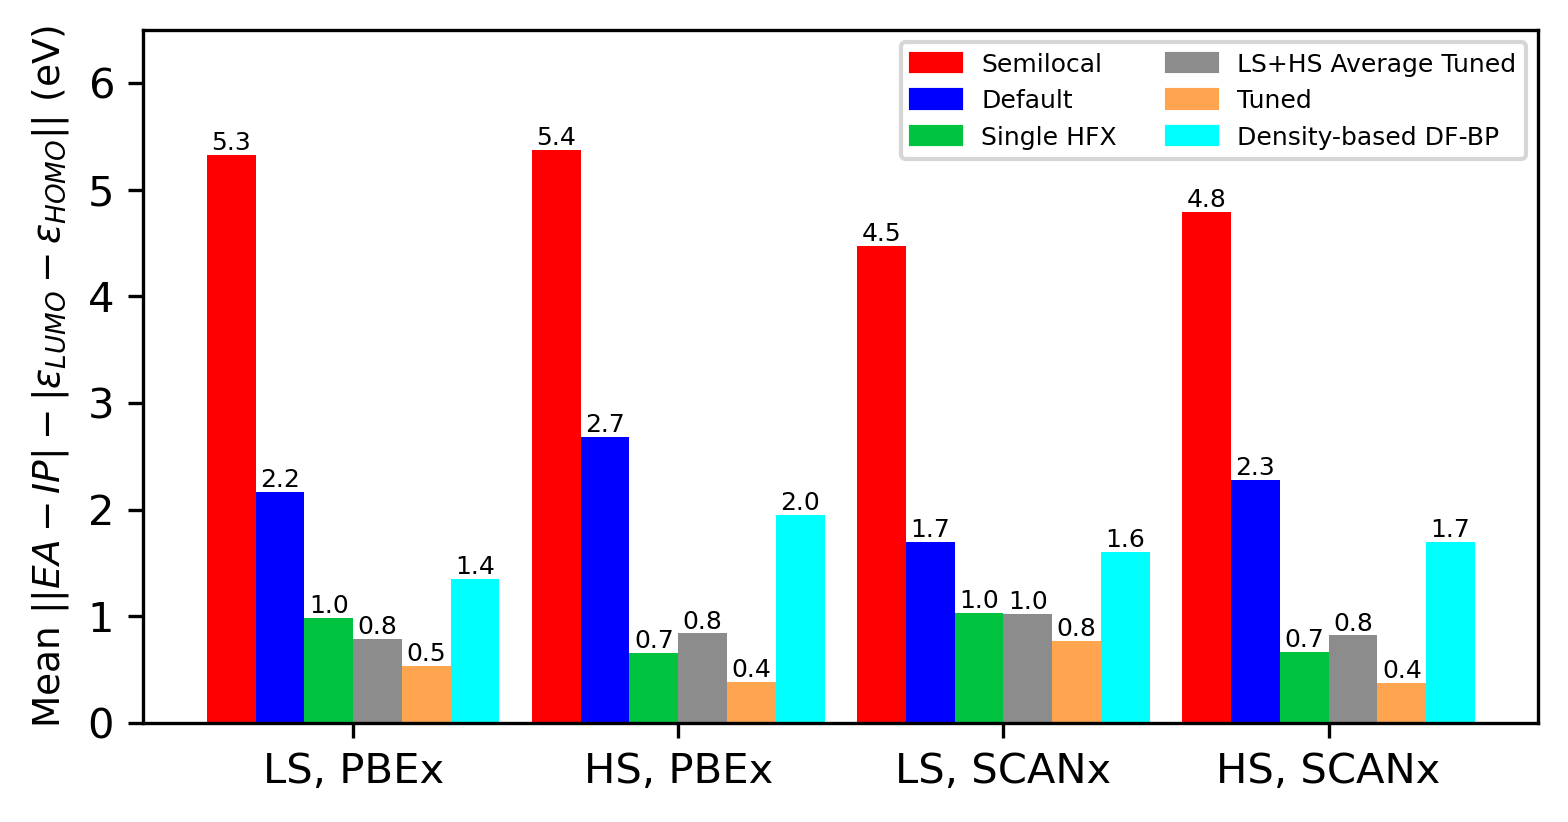

In [6]:
colors = ['#FF0000', '#0000FF', '#00C440', '#8c8c8c', '#FFA550', '#00FFFF']
sizes = np.arange(4)

#all errors: base_errs, hybrid_errs, ls_errs, hs_errs, avg_errs, pbe0_dfbp_errs, scan0_dfbp_errs, single_hfx_errs

dfbp_errs = pbe0_dfbp_errs[:2] + scan0_dfbp_errs[2:]
tuned_errs = [ls_errs[0], hs_errs[1], ls_errs[2], hs_errs[3]]

fig, ax = plt.subplots(figsize=(6, 3), dpi=300)
ax.bar(sizes-0.375, base_errs, 0.15, color=colors[0])
ax.bar_label(ax.containers[0], fmt=lambda x: f'{x:1.1f}', label_type='edge', fontsize=6)
ax.bar(sizes-0.225, hybrid_errs, 0.15, color=colors[1])
ax.bar_label(ax.containers[1], fmt=lambda x: f'{x:1.1f}', label_type='edge', fontsize=6)
ax.bar(sizes-0.075, single_hfx_errs, 0.15, color=colors[2])
ax.bar_label(ax.containers[2], fmt=lambda x: f'{x:1.1f}', label_type='edge', fontsize=6)
ax.bar(sizes+0.075, avg_errs, 0.15, color=colors[3])
ax.bar_label(ax.containers[3], fmt=lambda x: f'{x:1.1f}', label_type='edge', fontsize=6)
ax.bar(sizes+0.225, tuned_errs, 0.15, color=colors[4])
ax.bar_label(ax.containers[4], fmt=lambda x: f'{x:1.1f}', label_type='edge', fontsize=6)
ax.bar(sizes+0.375, dfbp_errs, 0.15, color=colors[5])
ax.bar_label(ax.containers[5], fmt=lambda x: f'{x:1.1f}', label_type='edge', fontsize=6)
ax.set_xticks(np.arange(4), ['LS, PBEx', 'HS, PBEx', 'LS, SCANx', 'HS, SCANx'])
ax.set_ylabel(r'Mean $\left| |EA-IP| - |\varepsilon_{LUMO}-\varepsilon_{HOMO}| \right|$ (eV)', fontsize=9)

ax.set_ylim((0,6.5))

import matplotlib.patches as mpatches
patch0 = mpatches.Patch(color='#FF0000', label='Semilocal')
patch1 = mpatches.Patch(color='#0000FF', label='Default')
patch2 = mpatches.Patch(color='#00C440', label='Single HFX')
patch3 = mpatches.Patch(color='#8c8c8c', label='LS+HS Average Tuned')
patch4 = mpatches.Patch(color='#FFA550', label='Tuned')
patch5 = mpatches.Patch(color='#00FFFF', label='Density-based DF-BP')
ax.legend(handles=[patch0, patch1, patch2, patch3, patch4, patch5], ncol=2, fontsize=6)